In [33]:
import json
import os
import urllib.request
import torch
from torch.utils.data import Dataset
import tiktoken
from functools import partial
from torch.utils.data import DataLoader
from gpt_download import download_and_load_gpt2
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
import re
import psutil


In [2]:
# Download the instruction dataset
def download_and_load_file(file_path, url):
    """
    Download a file from a URL and save it to the specified file path.
    """
    if not os.path.exists(file_path):
        print(f"Downloading {url} to {file_path}...")
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w', encoding="utf-8") as file:
                file.write(text_data)
        print("Download complete.")
    else:
        print(f"{file_path} already exists. Skipping download.")
        with open(file_path, 'r', encoding="utf-8") as file:
            text_data = file.read()
    
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    return data


In [3]:
file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"

data = download_and_load_file(file_path, url)
print(f"Loaded {len(data)} instruction-response pairs.")
print("Example entry: \n", data[50])
print("Another entry: \n", data[999])

instruction-data.json already exists. Skipping download.
Loaded 1100 instruction-response pairs.
Example entry: 
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Another entry: 
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [4]:
# Implement Alpaca prompt formatting
def format_input(entry):
    instruction_text = (
          f"Below is an instruction that describes a task. "
          f"Write a response that appropriately completes the request.\n\n"
          f"### Instruction:\n{entry['instruction']}\n\n"
    )
    
    input_text = (f"### Input:\n{entry['input']}\n\n" if entry['input'] else "")

    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"### Response:\n{data[50]['output']}\n\n"
print(model_input + desired_response)

model_input = format_input(data[999])
desired_response = f"### Response:\n{data[999]['output']}\n\n"
print(model_input + desired_response)

# Partition the dataset for training, validation, and testing
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.10)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Testing data size: {len(test_data)}")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


Training data size: 935
Validation data size: 55
Testing data size: 110


In [6]:
# Implement instruction dataset class
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instuction_plus_input = format_input(entry)
            response_text = f"### Response:\n{entry['output']}\n\n"
            full_text = instuction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, idx):
        return self.encoded_texts[idx]
    
    def __len__(self):
        return len(self.data)

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [8]:
# Create custom collate function
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_len=None, device="cpu"):
    """
    Custom collate function for DataLoader.
    """
    batch_max_len = max(len(item)+1 for item in batch)
    inputs_list, targets_list = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (new_item + [pad_token_id] * (batch_max_len - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_len is not None:
            inputs = inputs[:allowed_max_len]
            targets = targets[:allowed_max_len]

        inputs_list.append(inputs)
        targets_list.append(targets)
    
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)

    return inputs_tensor, targets_tensor

In [9]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = [inputs_1, inputs_2, inputs_3]

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [10]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print("Device: ", device)

Device:  mps


In [11]:
custom_collate_fn = partial(
    custom_collate_fn,
    allowed_max_len=1024,
    device=device
)

In [12]:
num_workers = 0
batch_size = 8

# Initialize data loaders
torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=True
)
val_dataset = InstructionDataset(val_data, tokenizer)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=False
)
test_dataset = InstructionDataset(test_data, tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=False
)

print("Train loader:")
for inputs, targets in train_dataloader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 69]) torch.

In [13]:
# Efficient multi-head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        key = self.W_key(x)
        query = self.W_query(x)
        value = self.W_value(x)

        key = key.view(b, num_tokens, self.num_heads, self.head_dim)
        value = value.view(b, num_tokens, self.num_heads, self.head_dim)
        query = query.view(b, num_tokens, self.num_heads, self.head_dim)

        key = key.transpose(1, 2)
        value = value.transpose(1, 2)
        query = query.transpose(1, 2)

        attn_scores = torch.matmul(query, key.transpose(2, 3))
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / key.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vector = torch.matmul(attn_weights, value).transpose(1, 2)
        context_vector = context_vector.contiguous().view(b, num_tokens, self.d_out)
        output = self.out_proj(context_vector)
        return output

# Implementation of LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

# Implementation of GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

# Implementation of FeedForward layer
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

# Implement the transformer block
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ffn = FeedForward(cfg)
        self.ln1 = LayerNorm(cfg["emb_dim"])
        self.ln2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x # shortcut for attention block
        x = self.ln1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x # shortcut for feedforward block
        x = self.ln2(x)
        x = self.ffn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

# Implementation of the full GPT model
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(* [TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return(logits)

In [14]:
# Loading OpenAI weights into our GPT model code
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right.shape}")
    return nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    # Load token embedding weights
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])
    
    # Load position embedding weights
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    
    # Load transformer block weights
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ffn.layers[0].weight = assign(
            gpt.trf_blocks[b].ffn.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ffn.layers[0].bias = assign(
            gpt.trf_blocks[b].ffn.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )

        gpt.trf_blocks[b].ffn.layers[2].weight = assign(
            gpt.trf_blocks[b].ffn.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ffn.layers[2].bias = assign(
            gpt.trf_blocks[b].ffn.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ln1.scale = assign(
            gpt.trf_blocks[b].ln1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].ln1.shift = assign(
            gpt.trf_blocks[b].ln1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )

        gpt.trf_blocks[b].ln2.scale = assign(
            gpt.trf_blocks[b].ln2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].ln2.shift = assign(
            gpt.trf_blocks[b].ln2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

        # Load final layer norm weights
        gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
        gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
        gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [15]:
# Set up configurations for the model
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12
    },
    "gpt2-medium (355M)": {
        "emb_dim": 1024,
        "n_heads": 16,
        "n_layers": 24
    },
    "gpt2-large (774M)": {
        "emb_dim": 1280,
        "n_heads": 20,
        "n_layers": 36
    },
    "gpt2-xl (1558M)": {
        "emb_dim": 1600,
        "n_heads": 25,
        "n_layers": 48
    }
}

In [16]:
# Choose model
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
print(f"Model size: {model_size}")

Model size: 355M


In [17]:
# Download and load the model
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [18]:
# Load weights into the model
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [19]:
# Test the model with a sample input
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'




In [20]:
# Implement text to token IDs and vice versa
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    decoded = tokenizer.decode(flat.tolist())
    return decoded

# Implement text generation function with temperature and top-k sampling
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            logits = logits[:, -1, :]
            if top_k is not None:
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(
                    logits < min_val,
                    torch.tensor(float("-inf")).to(logits.device),
                    logits
                )
            if temperature > 0.0:
                logits = logits / temperature
                probabilities = torch.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probabilities, num_samples=1)
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            if idx_next == eos_id:
                break
            idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [21]:
# Test the generate function
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
# print(generated_text)
print(response_text)

### Response:

The chef cooks the meal every day.


### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal


In [22]:
# Implement the loss calculation function
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    logits_flat = logits.flatten(0, 1)
    targets_flat = target_batch.flatten()
    loss = nn.functional.cross_entropy(logits_flat, targets_flat)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    avg_loss = total_loss / num_batches
    return avg_loss

In [23]:
# Implement the training loop
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Logging gradients for debugging
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         grad = param.grad
            #         print(f"{name}: grad mean={grad.mean():.6f}, std={grad.std():.6f}, max={grad.abs().max():.6f}")
            #         grad_norm = grad.norm().item()
            #         print(f"{name}: grad norm = {grad_norm:.4f}")
            #         if grad_norm > 1000:  # Adjust threshold as needed
            #             print(f"🚨 Warning: Exploding gradient in {name}!")
            #     else:
            #         print(f"{name}: grad is None")

            # add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.6)

            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch* {epoch+1}, (Step {global_step:06d}) :" 
                      f"Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}")
        
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
            eos_id=50256
            )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].strip()
    print(generated_text)
    model.train()

In [24]:
# Send model to the device
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [25]:
# Test the loss calculation function
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_dataloader, model, device, num_batches=5)

print(f"Train loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Train loss: 3.9327
Validation loss: 3.8647


In [26]:
# Train the model
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device, num_epochs=num_epochs, 
    eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Execution time: {execution_time_minutes:.2f} minutes")

Epoch* 1, (Step 000000) :Train Loss: 2.7525, Val Loss: 2.7335
Epoch* 1, (Step 000005) :Train Loss: 1.1577, Val Loss: 1.0916
Epoch* 1, (Step 000010) :Train Loss: 0.8406, Val Loss: 0.9223
Epoch* 1, (Step 000015) :Train Loss: 0.8198, Val Loss: 0.8737
Epoch* 1, (Step 000020) :Train Loss: 0.7403, Val Loss: 0.8481
Epoch* 1, (Step 000025) :Train Loss: 0.7402, Val Loss: 0.8334
Epoch* 1, (Step 000030) :Train Loss: 0.7706, Val Loss: 0.8057
Epoch* 1, (Step 000035) :Train Loss: 0.6973, Val Loss: 0.7874
Epoch* 1, (Step 000040) :Train Loss: 0.6606, Val Loss: 0.7955
Epoch* 1, (Step 000045) :Train Loss: 0.6132, Val Loss: 0.7778
Epoch* 1, (Step 000050) :Train Loss: 0.6476, Val Loss: 0.7674
Epoch* 1, (Step 000055) :Train Loss: 0.7439, Val Loss: 0.7466
Epoch* 1, (Step 000060) :Train Loss: 0.7010, Val Loss: 0.7416
Epoch* 1, (Step 000065) :Train Loss: 0.6403, Val Loss: 0.7357
Epoch* 1, (Step 000070) :Train Loss: 0.5184, Val Loss: 0.7257
Epoch* 1, (Step 000075) :Train Loss: 0.5498, Val Loss: 0.7229
Epoch* 1

In [27]:
# Function to plot training and validation losses
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label='Train Loss', color='blue')
    ax1.plot(epochs_seen, val_losses, label='Validation Loss', color='orange')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens Seen')
    fig.tight_layout()
    plt.show() # Uncomment to show the plot

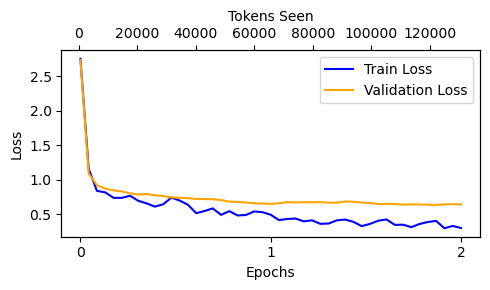

In [28]:
# Plot the losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [29]:
# Extract sample test responses
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    print(input_text)
    
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    print(f"\nCorrect response:\n{entry['output']}")
    print(f"Generated response:\n{response_text.strip()}")
    print("-" * 50)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.



Correct response:
The car is as fast as lightning.
Generated response:
The car is as fast as a cheetah.
--------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?



Correct response:
The type of cloud typically associated with thunderstorms is cumulonimbus.
Generated response:
A thunderstorm is a type of cloud that typically forms when thunderstorms produce thunderstorms.
--------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.



Correct response:
Jane Aust

In [31]:
# Genrate and save test set responses
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["generated_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

print(test_data[0])

100%|██████████| 110/110 [02:32<00:00,  1.39s/it]

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'generated_response': 'The car is as fast as a cheetah.'}


In [35]:
# Save the model
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}_sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved to {file_name}")

Model saved to gpt2-medium355M_sft.pth


In [36]:
# Function to check if a process is running
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

In [37]:
# Check the ollama is running
ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running: ", check_if_running("ollama"))

Ollama running:  True


In [39]:
# Function to query local ollama model
def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

In [40]:
# Test that ollama is running
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [41]:
# Test the ollama scoring model with a few examples
for entry in test_data[:3]:
    prompt = (
        f"Given the model input `{format_input(entry)}` "
        f"and the correct output `{entry['output']}`, "
        f"score the response `{entry['generated_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry["output"])
    print("\nModel response:")
    print(">>", entry["generated_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n", "-" * 50)


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> I'd score this response a 90 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to that of an animal (a cheetah).
* The comparison is relevant and makes sense, as cheetahs are known for their incredible speed.
* The language is simple and easy to understand, making it accessible to a wide range of readers.

The only reason I wouldn't give it a perfect score is that the comparison could be considered slightly less vivid or surprising than some other options (like "as fast as lightning" or "as fast as a speeding bullet"). However, overall, this response effectively completes the request and provides a clear and engaging comparison.

 --------------------------------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of

In [45]:
# Function to evaluate instruction finetuning model
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Generating scores"):
        prompt = (
            f"Given the model input `{format_input(entry)}` "
            f"and the correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}` "
            f"on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        # print('<<<', entry['generated_response'], '>>>\n') # Uncomment for debugging
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Error converting score: {score}")
            continue

    return scores

In [46]:
# Generate average scores for the test set
scores = generate_model_scores(test_data, "generated_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}\n")

Generating scores:   7%|▋         | 8/110 [00:03<01:07,  1.51it/s]

Error converting score: I'd rate my response as follows:

* For the instruction "Generate a humorous anecdote", I would give myself a score of 80. While my response is not a traditional joke or pun, it's a lighthearted and playful story that might elicit a chuckle.
* For the instruction "What is the opposite of 'happy'"', I would give myself a score of 100. My response is a straightforward and accurate answer to the question.

So, my scores are: 80 and 100.


Generating scores: 100%|██████████| 110/110 [00:27<00:00,  4.04it/s]

Number of scores: 109 of 110
Average score: 61.73

